In [1]:
import torch
import numpy as np
import torchvision
import matplotlib 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader 
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root = '/home/invinci/Me/Deep Learning/Working with Images(MNIST)/raw/',download=False, transform=ToTensor())

Let's look at a couple of images from the dataset. The images are convertedto PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use plt.imshow to display with images. However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image.  

image.shape:  torch.Size([1, 28, 28])
Label:  5


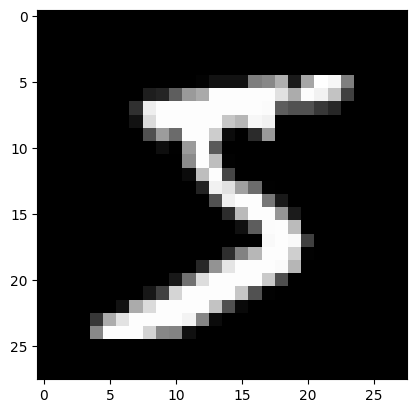

In [3]:
image, label = dataset[0]
print('image.shape: ', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label: ', label)

Next, let's use the random_split  helper function to set aside 10000 images for our validation set. 

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
# We can now create Pytorch data loaders for training and validation
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)

Can you figure out the purpose of the arguments num_workers and pin_memory? Try looking into the documentation: https://pytorch.org/docs/stable/data.html 

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also the .permute method on tensor to move the channels to the last dimension, as expectedby matplotlib.

images.shape:  torch.Size([128, 1, 28, 28])


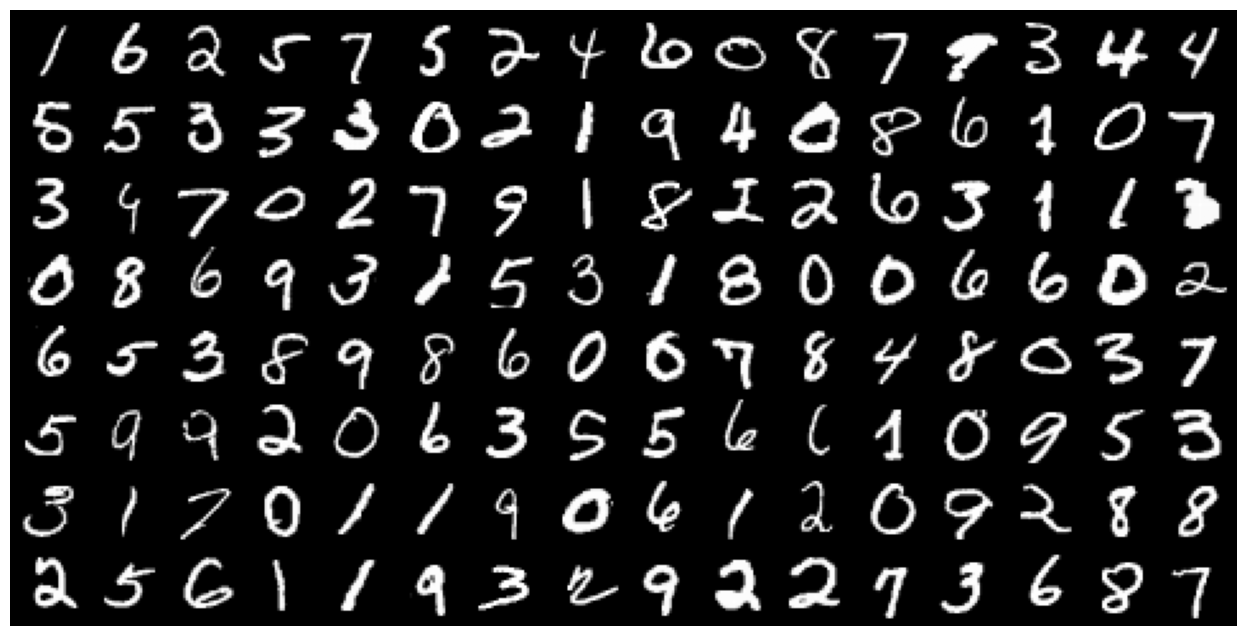

In [6]:
for images, _ in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28  images into vectors of size 784, so they can be passed into an nn.Linear object. 

In [7]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape: ', inputs.shape)
    break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [8]:
input_size = inputs.shape[-1]
hidden_size = 32

In [9]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [10]:
inputs.shape

torch.Size([128, 784])

In [11]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: ', layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using torch.allclose. For a more detailed explanation, review the tutorial on linear regression. 

In [12]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [13]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e, each element of `layer_outputs` is a weighted sum of elements `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function.

We can use the F.relu method to apply ReLU to the elements of a tensor.

In [14]:
F.relu(torch.tensor([[1, -1, 0],
                    [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [15]:
layer1_outputs.shape

torch.Size([128, 32])

In [16]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape: ', relu_outputs.shape)
print('min(layer1_outputs): ', torch.min(layer1_outputs).item())
print('min(relu_outputs): ', torch.min(relu_outputs).item())

relu_outputs.shape:  torch.Size([128, 32])
min(layer1_outputs):  -1.1003272533416748
min(relu_outputs):  0.0


Now that we've applied a  non-linear  activation function, relu_outputs and inputs do not have a linear relationship. We refer to ReLU as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).


In [17]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [18]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights `layer1` and `layer2` using gradient descent.

In [19]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3063, grad_fn=<NllLossBackward0>)

Thus our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.  

In [20]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters inside the model. We can also introduce new hidden layers and apply the same non-linear activation function after each hidden layer.  

The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large and deep neural network can compute any arbitrary function i.e it can learn rich and complex non-linear relationships between inputs and targets.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [21]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias 

# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means
    
    - Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.
    - The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually 
    - We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.
    - The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent. 
  

In [22]:
# Let's define the model by extending the nn.Module class from PyTorch.

class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # Hidden Layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # Output Layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        """Returns the loss for a batch of training data"""
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        acc = accuracy(out, labels)             # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine Losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()          # Combine Accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f} ".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
# We'll create a model that contains a hidden layer with 32 activations.

input_size = 784
hidden_size = 32 # You can change this
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [25]:
# Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [26]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss: ', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss:  2.3118643760681152
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0582, -0.1020,  0.1114,  0.1932,  0.0728,  0.0049,  0.1632,  0.0430,
         -0.1576, -0.0986],
        [-0.2393, -0.1231,  0.1741,  0.2380,  0.1354,  0.0452,  0.1113,  0.0454,
         -0.2647,  0.0379]])


### Using a GPU 

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks.

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available()

In [27]:
torch.cuda.is_available()

# I Personally dont have access to GPU  so either run these codes under GPU section on Colab/Kaggle for free or a device with GPU

False

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

In [29]:
device = get_default_device()
device

device(type='cpu')

In [30]:
# Next let's define a function that can move data and model to a chosen device.

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [31]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader.
All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [32]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below. 

In [33]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [34]:
# We can now wrap our data loaders using DeviceDataLoader.

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a device property which includes that word `cuda`. Let's verify this by looking at a batch of data from valid_dl.

In [35]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([7, 0, 6, 9, 9, 1, 6, 4, 7, 2, 3, 7, 4, 0, 1, 1, 0, 5, 2, 8, 3, 6, 8, 3,
        7, 1, 7, 6, 7, 8, 3, 7, 5, 5, 6, 1, 6, 9, 2, 6, 2, 1, 1, 3, 8, 2, 9, 0,
        5, 5, 4, 2, 9, 2, 7, 8, 4, 7, 1, 4, 3, 2, 8, 4, 3, 3, 1, 1, 4, 1, 7, 4,
        0, 1, 1, 2, 4, 3, 4, 1, 7, 8, 9, 6, 8, 6, 2, 1, 3, 4, 4, 7, 6, 2, 5, 1,
        8, 6, 7, 2, 0, 2, 4, 0, 9, 2, 2, 6, 1, 2, 8, 4, 9, 7, 1, 3, 3, 7, 0, 3,
        2, 8, 0, 4, 8, 9, 5, 0, 0, 5, 5, 8, 5, 6, 5, 3, 6, 7, 6, 6, 6, 8, 8, 4,
        4, 1, 1, 7, 2, 4, 3, 1, 4, 1, 9, 5, 4, 7, 5, 2, 3, 1, 4, 8, 2, 3, 6, 1,
        7, 3, 1, 6, 7, 2, 1, 7, 4, 7, 2, 8, 5, 2, 4, 7, 0, 4, 2, 3, 3, 4, 6, 8,
        6, 9, 4, 3, 4, 6, 1, 6, 9, 0, 4, 5, 3, 6, 3, 1, 2, 8, 4, 8, 7, 2, 8, 9,
        3, 6, 5, 2, 3, 4, 6, 1, 6, 7, 2, 6, 7, 9, 0, 7, 9, 2, 8, 9, 4, 8, 0, 0,
        5, 2, 9, 9, 9, 3, 6, 2, 6, 7, 3, 3, 6, 3, 6, 4])


### Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [36]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs  = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss =  model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.


In [37]:
# Model (On GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [38]:
# Let's see how the model performs on the validation set with the initial set of weights and biases.

history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3021578788757324, 'val_acc': 0.07773437350988388}]

The initial accuracy is around 10% a sone might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly)

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5

In [39]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2099, val_acc: 0.9409 
Epoch [1], val_loss: 0.1884, val_acc: 0.9426 
Epoch [2], val_loss: 0.1367, val_acc: 0.9585 
Epoch [3], val_loss: 0.1528, val_acc: 0.9541 
Epoch [4], val_loss: 0.1367, val_acc: 0.9577 


In [40]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1038, val_acc: 0.9682 
Epoch [1], val_loss: 0.1023, val_acc: 0.9692 
Epoch [2], val_loss: 0.1020, val_acc: 0.9685 
Epoch [3], val_loss: 0.1008, val_acc: 0.9685 
Epoch [4], val_loss: 0.1013, val_acc: 0.9688 


In [49]:
history+= fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0985, val_acc: 0.9694 
Epoch [1], val_loss: 0.0985, val_acc: 0.9693 
Epoch [2], val_loss: 0.0985, val_acc: 0.9692 
Epoch [3], val_loss: 0.0985, val_acc: 0.9692 
Epoch [4], val_loss: 0.0984, val_acc: 0.9692 


96% is pretty good! We can now plot the losses & accuracies to study how the model improves over time.

Text(0.5, 1.0, 'Loss vs. No. of epochs')

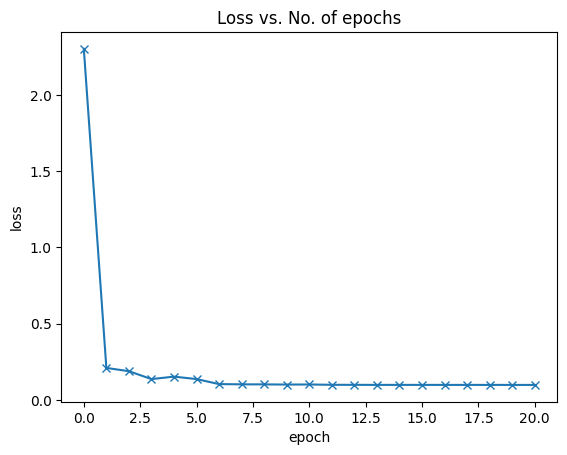

In [50]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

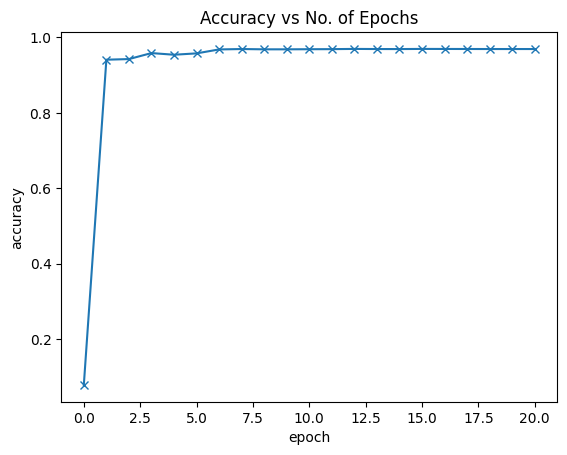

In [51]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. I encourage you to try out both these approaches and see which one works better.

### Testing with Individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin be recreating the test dataset with the `ToTensor` transform. 

In [43]:
# Define test dataset

test_dataset = MNIST(root='/home/invinci/Me/Deep Learning/Working with Images(MNIST)/raw/',
                     train = False,
                     transform=ToTensor())

In [53]:
# Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Let's try it out with a few images.

Label:  7 Predicted:  7


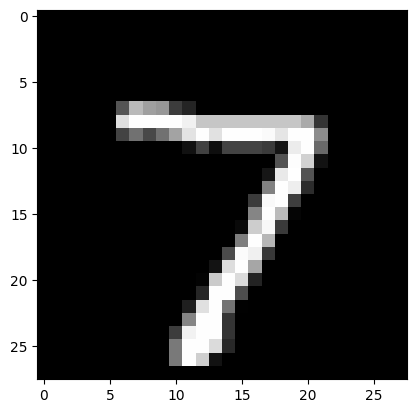

In [54]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, 'Predicted: ', predict_image(img, model))


Label:  4 Predicted:  4


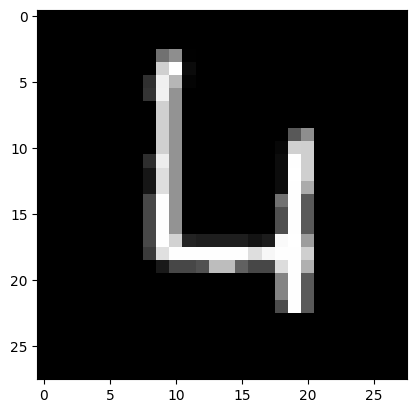

In [55]:
img, label = test_dataset[1938]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, 'Predicted: ', predict_image(img, model))

Label:  2 Predicted:  2


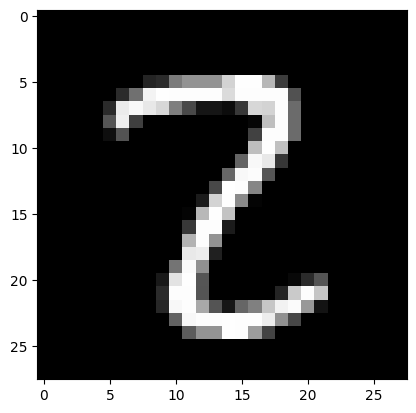

In [56]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, 'Predicted: ', predict_image(img, model))

Label:  9 Predicted:  9


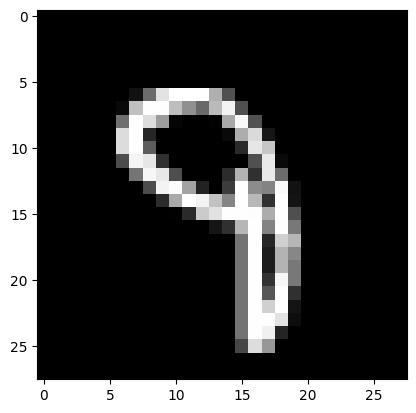

In [57]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, 'Predicted: ', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hyperparameters. 

As a final step, let's look  at the overall loss and accuracy of the model on the test set.

In [58]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09894666820764542, 'val_acc': 0.9708007574081421}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set(which often comes from the real world)

#### Summary and Further Reading 

Here is a summary of the topics covered in this tutorial:
    
- We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

- We defined some utilities like `get_default_device`, `to_Device` and 'DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

- We were able to use the exact same training loop: `fit` function we had defined earlier to train out model and evaluate it using the validation dataset.

There's a lot of scope to experiment here, and I encourage you to use interactive nature of Jupyter to play around with the various parameters. Here are a few Ideas:

- Try changing the size of the hidden layer, or add more hidden layers and see if you can achieve a higher accuracy.

- Try changing batch size and learning rate to see if you can achieve the same accuracy in fewer epochs.

- Compare the training times on a CPU vs GPU. Do you see a significant difference. How does it vary with the size of the dataset and the size of the model (no. of weights and parameters)?

- Try building a model for another dataset, such as the CIFAR10 or CIFAR100 datasets.


A Video from 3Blue1Brown about What is a neural network? Can check this out.
